## EDA OF THE DATASET

In [5]:
# Import the pandas library, which is essential for data manipulation and analysis.
import pandas as pd

#### --- 1. Load the Datasets ---

In [6]:
# Load the two CSV files into separate pandas DataFrames.
try:
    df_true = pd.read_csv('True.csv')
    df_fake = pd.read_csv('Fake.csv')
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print("Error: Files not found. Please update the file paths.")
    exit()

Datasets loaded successfully!


#### --- 2. Add Labels ---

In [7]:
# Labels: 0 = Real News, 1 = Fake News.
df_true['label'] = 0
df_fake['label'] = 1

##### --- 3. Merge the DataFrames ---

In [8]:
df_merged = pd.concat([df_true, df_fake], ignore_index=True)


#### --- 4. Shuffle the Data ---

In [9]:
# It's crucial to shuffle the data to ensure that when we train a model,
# it doesn't learn from the order of the data (all real then all fake).
df_shuffled = df_merged.sample(frac=1).reset_index(drop=True)

#### --- 5. Displaying Final Result ---

In [10]:
print("\n--- Shuffled DataFrame Head ---")
print(df_shuffled.head(10))


--- Shuffled DataFrame Head ---
                                               title  \
0  WATCH: HOME IMPROVEMENT’S TIM ALLEN Reminds Us...   
1  Billionaire ‘Bilderberger’ David Rockefeller d...   
2  BENGHAZI SPOKESLIAR SUSAN RICE TELLS CNN: ‘We ...   
3  Tanzanian president discloses salary, one of l...   
4  U.S. nuclear general says would resist 'illega...   
5  House Speaker Ryan says contested Republican c...   
6   White House Officials Admit That Trump LIED A...   
7   Investigators Reveal How Ex-DNC Staffer Likel...   
8              “I Think My Dog’s A Democrat” [VIDEO]   
9  Exclusive: Colombia's ELN says it killed Russi...   

                                                text       subject  \
0  NOTE TO TARGET There Aren t Any Feminine Produ...     left-news   
1   The Trilateral Commission is international an...       US_News   
2  Tell us Susan what s worse, Iran with a nuclea...     left-news   
3  DAR ES SALAAM (Reuters) - Tanzanian President ...     worldnews   


In [11]:
# Import libraries for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer



In [12]:
# Set a style for all plots
sns.set_style("whitegrid")

### PERFORMING EDA

#### --- 1. Initial Data Check ---

In [13]:
print("--- Dataset Shape ---")
print(f"The dataset has {df_shuffled.shape[0]} rows and {df_shuffled.shape[1]} columns.")

print("\n--- Missing Values ---")
print(df_shuffled.isnull().sum())

--- Dataset Shape ---
The dataset has 44898 rows and 5 columns.

--- Missing Values ---
title      0
text       0
subject    0
date       0
label      0
dtype: int64


#### 2. Target Variable Distribution


--- Class Distribution ---
label
1    23481
0    21417
Name: count, dtype: int64


C:\Users\Isha Singh\AppData\Local\Temp\ipykernel_19020\599343366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_shuffled, palette=['#43a047', '#d32f2f'])


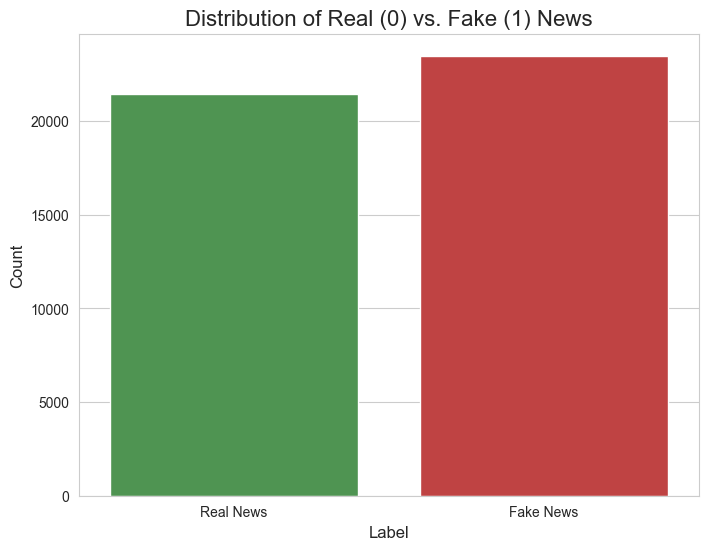

In [14]:
# This is important to check for class imbalance.
print("\n--- Class Distribution ---")
print(df_shuffled['label'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_shuffled, palette=['#43a047', '#d32f2f'])
plt.title('Distribution of Real (0) vs. Fake (1) News', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Real News', 'Fake News'])
plt.show()

Observation: The dataset is fairly well-balanced, which is great for training a model.

#### 3. Text Feature Engineering

In [15]:
# We will create new features from the text to see if their characteristics differ.
# We will analyze the length of the article text and the total word count.
df_shuffled['text_length'] = df_shuffled['text'].apply(lambda s: len(str(s)))

# Calculate the word count in each article
df_shuffled['word_count'] = df_shuffled['text'].apply(lambda s: len(str(s).split()))

print("\n--- New Features Head ---")
print(df_shuffled[['label', 'text_length', 'word_count']].head())





--- New Features Head ---
   label  text_length  word_count
0      1         2248         387
1      1         4109         620
2      1         2231         383
3      0         2194         358
4      0         2352         398


#### 4. Visualizing Text Lengths

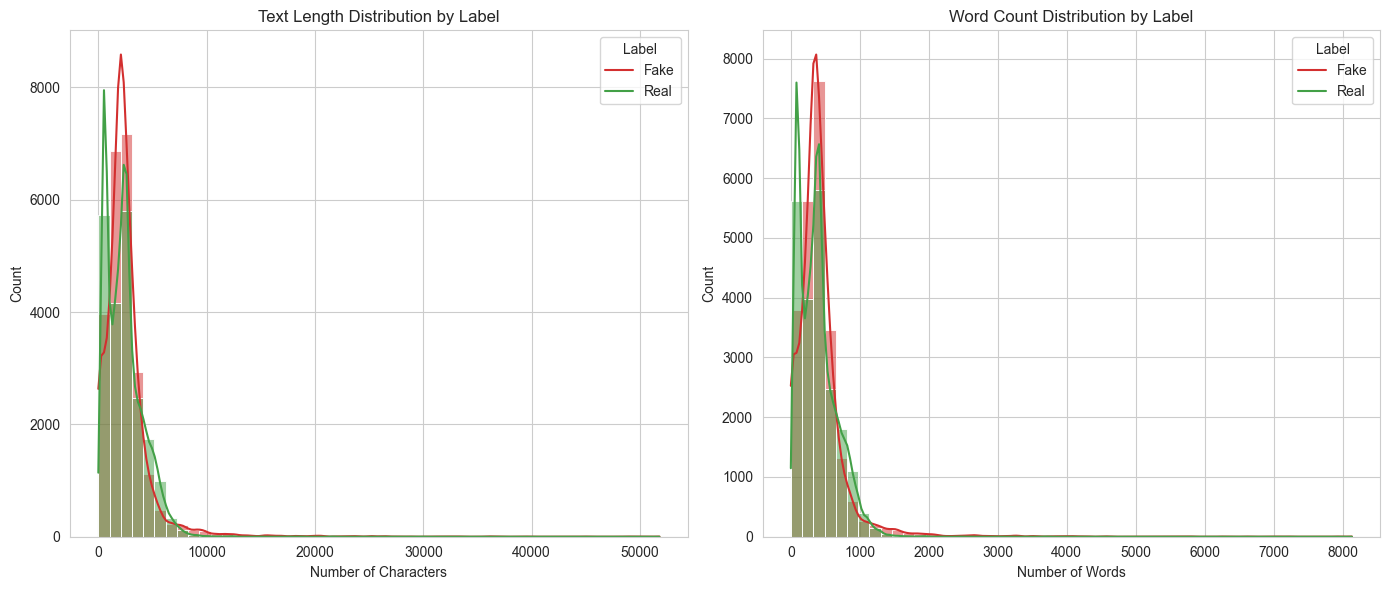

In [16]:
plt.figure(figsize=(14, 6))

# Plot for Text Length
plt.subplot(1, 2, 1)
sns.histplot(data=df_shuffled, x='text_length', hue='label', bins=50, kde=True, palette=['#43a047', '#d32f2f'])
plt.title('Text Length Distribution by Label')
plt.xlabel('Number of Characters')
plt.legend(title='Label', labels=['Fake', 'Real'])

# Plot for Word Count
plt.subplot(1, 2, 2)
sns.histplot(data=df_shuffled, x='word_count', hue='label', bins=50, kde=True, palette=['#43a047', '#d32f2f'])
plt.title('Word Count Distribution by Label')
plt.xlabel('Number of Words')
plt.legend(title='Label', labels=['Fake', 'Real'])

plt.tight_layout()
plt.show()

Observation: Fake news articles appear to be, on average, shorter than real news articles.

#### 5. Analyzing Most Common Words (N-grams)

In [17]:
real_news_text = df_shuffled[df_shuffled['label'] == 0]['text'].fillna('')
fake_news_text = df_shuffled[df_shuffled['label'] == 1]['text'].fillna('')

In [19]:
def plot_top_tfidf_ngrams(corpus, title, n=20, ngram_range=(1, 1)):
    """Helper function to plot top n-grams based on TF-IDF scores."""
    # Use TfidfVectorizer to find the most important words/phrases.
    # It weighs words by how important they are to a document.
    vec = TfidfVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)

    # Sum the TF-IDF scores for each term across all documents
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Create a DataFrame of the top N n-grams
    top_df = pd.DataFrame(words_freq[:n], columns=['N-gram', 'TF-IDF Score'])

    # Plot the results
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TF-IDF Score', y='N-gram', data=top_df, palette='plasma')
    plt.title(title, fontsize=16)
    plt.xlabel('Total TF-IDF Score', fontsize=12)
    plt.ylabel('N-gram', fontsize=12)
    plt.show()


--- Generating plots for most important words (TF-IDF)... ---


C:\Users\Isha Singh\AppData\Local\Temp\ipykernel_19020\3172717794.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='N-gram', data=top_df, palette='plasma')


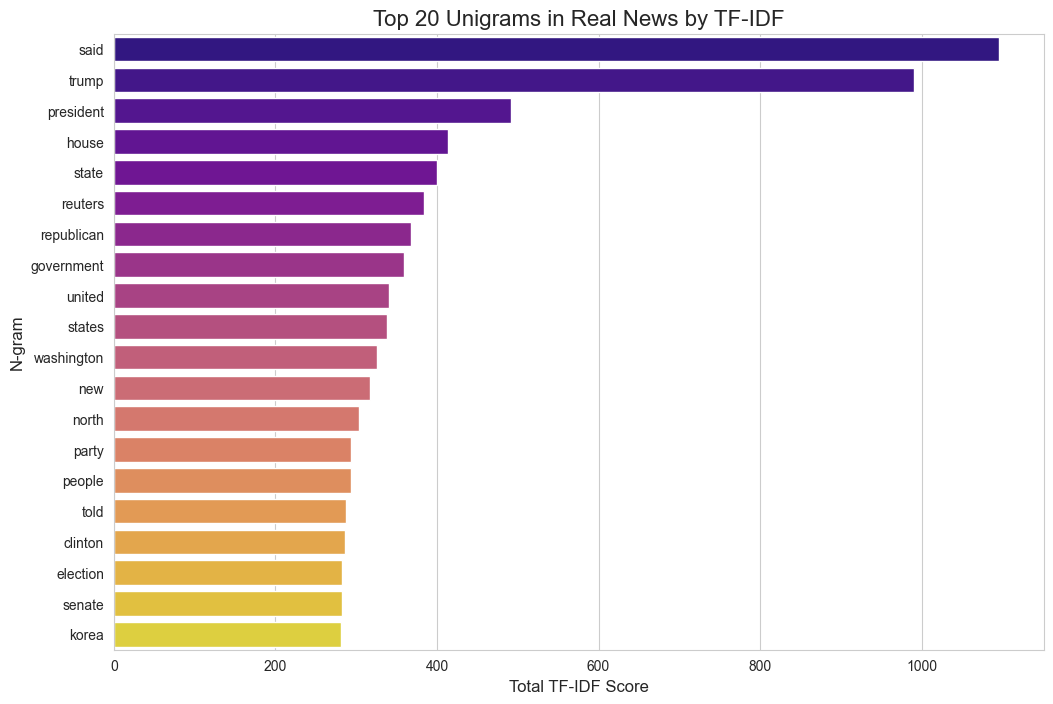

C:\Users\Isha Singh\AppData\Local\Temp\ipykernel_19020\3172717794.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='N-gram', data=top_df, palette='plasma')


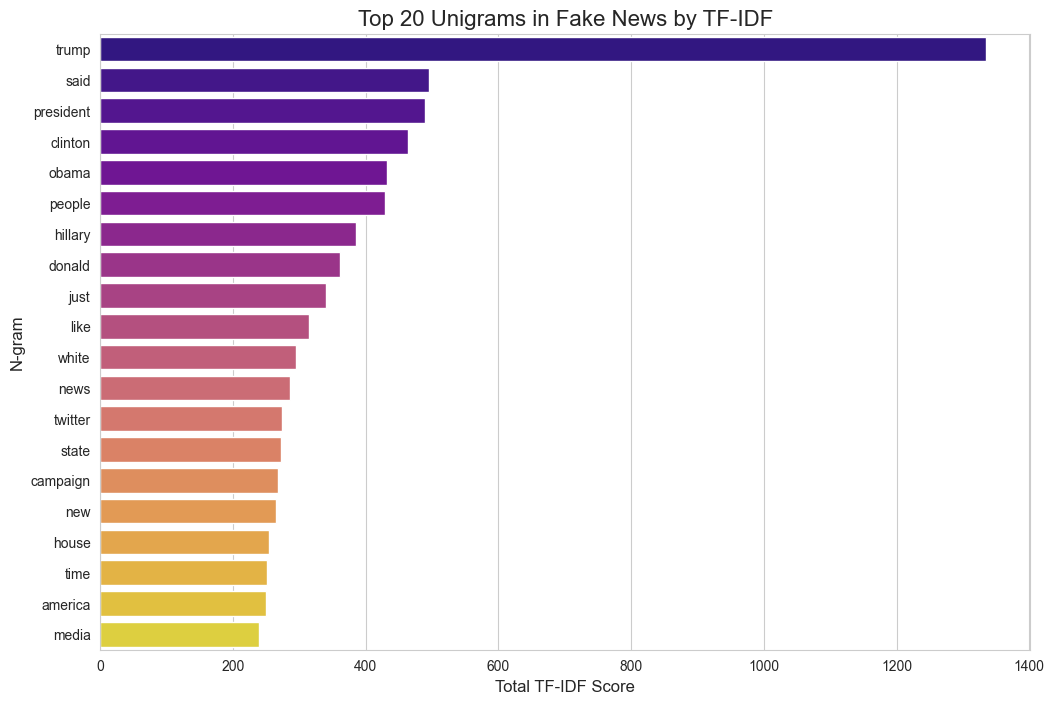

In [20]:
# --- Visualize Top Unigrams (single words) by TF-IDF Score ---
print("\n--- Generating plots for most important words (TF-IDF)... ---")
plot_top_tfidf_ngrams(real_news_text, 'Top 20 Unigrams in Real News by TF-IDF', n=20, ngram_range=(1, 1))
plot_top_tfidf_ngrams(fake_news_text, 'Top 20 Unigrams in Fake News by TF-IDF', n=20, ngram_range=(1, 1))


--- Generating plots for most important two-word phrases (TF-IDF)... ---


C:\Users\Isha Singh\AppData\Local\Temp\ipykernel_19020\3172717794.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='N-gram', data=top_df, palette='plasma')


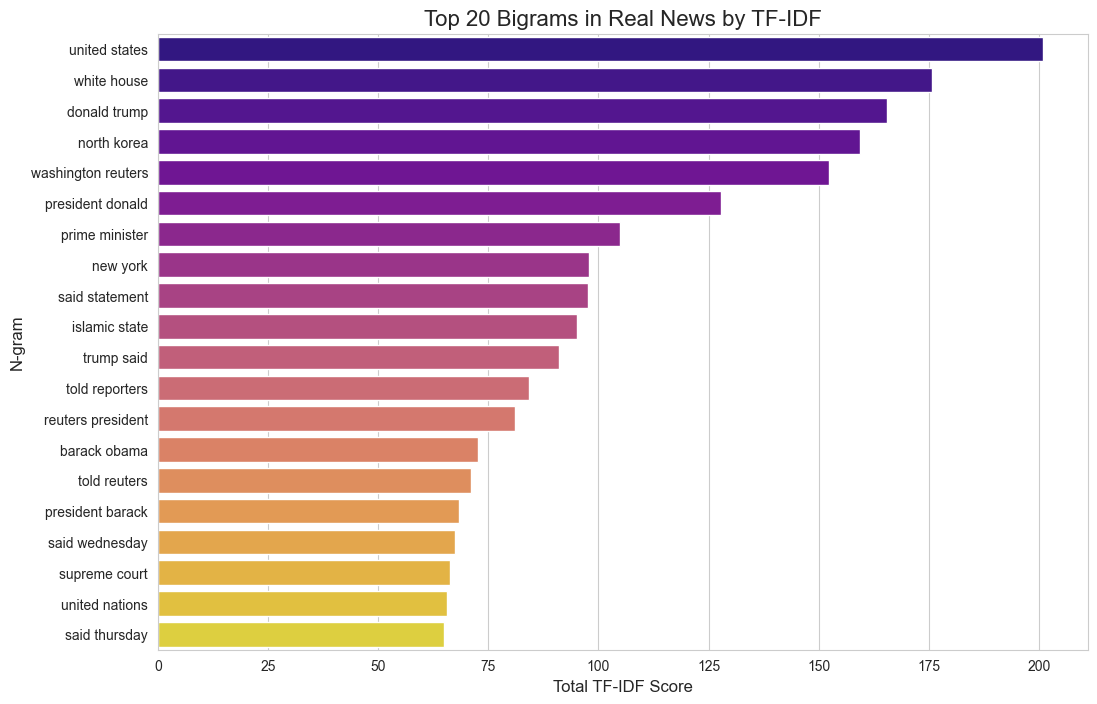

C:\Users\Isha Singh\AppData\Local\Temp\ipykernel_19020\3172717794.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='N-gram', data=top_df, palette='plasma')


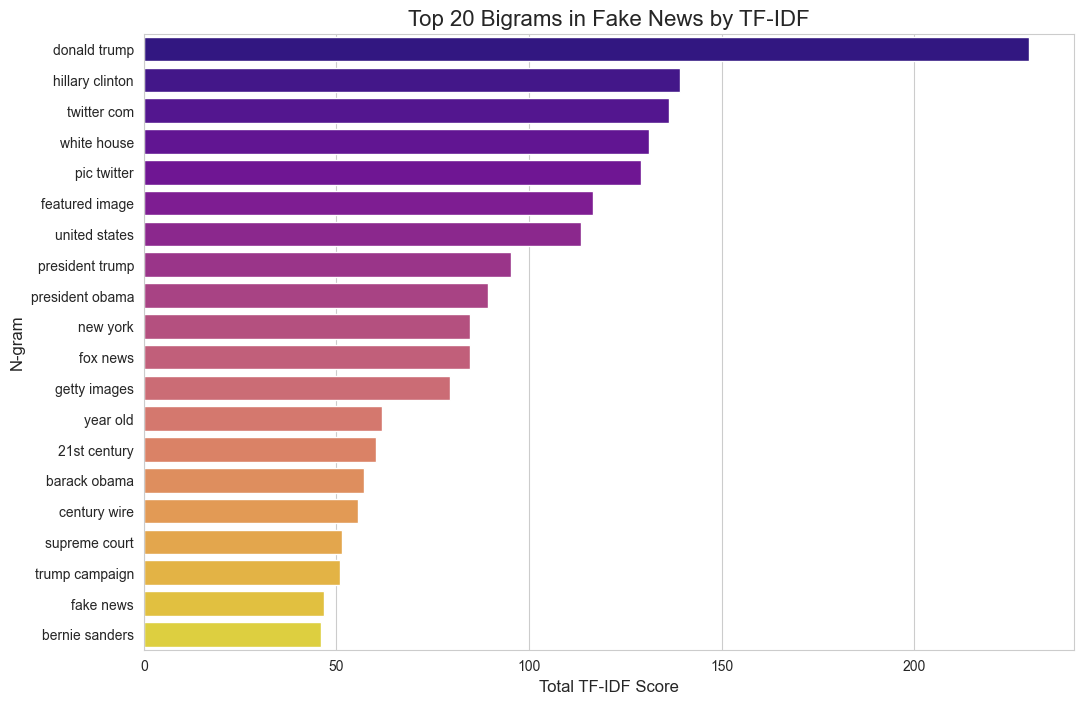

In [21]:
# --- Visualize Top Bigrams (two-word phrases) by TF-IDF Score ---
print("\n--- Generating plots for most important two-word phrases (TF-IDF)... ---")
plot_top_tfidf_ngrams(real_news_text, 'Top 20 Bigrams in Real News by TF-IDF', n=20, ngram_range=(2, 2))
plot_top_tfidf_ngrams(fake_news_text, 'Top 20 Bigrams in Fake News by TF-IDF', n=20, ngram_range=(2, 2))

### ---  SAVING THE RESULT DATASET ---

In [23]:
import os
dir_path = "notebook"
filename = 'model_data.csv'
full_path = os.path.join(dir_path,filename)
os.makedirs(dir_path,exist_ok=True)

try:
    df_shuffled.to_csv(full_path,index=False)
    print(f" DataFrame successfully saved to: '{full_path}'")
except Exception as e:
    print(f" An error occurred while saving the file: {e}")

 DataFrame successfully saved to: 'notebook\model_data.csv'
